This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Orientation dependence of the projection center

In this tutorial, we will see that the error in the projection center (PC) estimated from pattern matching can be orientation dependent.
When finding an average PC to use for indexing, it is therefore important to average PCs from not only many patterns, but from many patterns from different grains as well, if possible.

The orientation dependence of the PC error is nicely demonstrated by <cite data-cite="pang2020global">Pang et al. (2020)</cite>.
They simulateneously optimize the orientation and PCs of experimental nickel patterns from an openly available dataset, released by <cite data-cite="jackson2019dictionary">Jackson et al. (2019)</cite>.
To test their optimization routine, they compare optimized PCs to those expected from geometrical considerations.
When the dataset was acquired, the sample was tilted $\sigma = 75.7^{\circ}$ towards the detector, while the detector was tilted $\theta = 10^{\circ}$ away from the sample.
These tilts give a combined $\alpha = 90^{\circ} - \sigma + \theta$ tilt about the detector $X_d$ axis, which brings the sample normal parallel to the detector normal.
A scan of (n rows, m columns) = (151, 181) patterns with a nominal step size of 1.5 $\mu$m was acquired in a nominally regular grid on the sample, with the sample $y$ direction increasing "up the sample".
Given these geometrical considerations, the PC is expected to change following the following equations:

\begin{align}
\frac{PC_x}{\Delta y} &= 1,\\
\frac{PC_y}{\Delta y} &= \cos{\alpha} \cdot \frac{1}{\delta},\\
\frac{PC_z}{\Delta y} &= \sin{\alpha}.
\end{align}

Here, Bruker's PC convention is used (see the [reference frame tutorial](reference_frames.rst)), and $\delta$ is the detector pixel size.
It was $\delta = 59.2$ $\mu$m on the detector used in the experiment.

Pang and co-workers optimize the orientation solutions and PCs saved with the experimental data as determined from Hough indexing with EDAX OIM.
Here, we will do the following:

1. Obtain a good starting PC for the refinement:
    1. Optimize the PC of 49 patterns extracted in a (7, 7) grid from the full dataset using Hough indexing. We will use the EDAX OIM PC as the initial guess.
    2. Index the 49 patterns using Hough indexing.
    3. Refine the orientations and PCs using pattern matching.
    4. Calculate an average PC using the reliably refined PCs.
2. Index all (151, 181) patterns using Hough indexing with the average PC.
3. Refine Hough indexed orientations and average PC using pattern matching. This will only be done for a vertical slice of the full dataset (the same used by Pang and co-workers). This slice has shape (151, 10).

Finally, we will average the refined PCs along the horizontal (giving one PC per 151 vertical position) and compare these to the ones expected from the equations above.

Pang and co-workers use the global optimization algorithm SNOBFIT to optimize orientations and PCs simultaneously.
Here, we will use the local optimization algorithm Nelder-Mead, as implemented in NLopt, and see that we obtain comparable results.

<div class="alert alert-info">

Note

kikuchipy cannot depend on PyEBSDIndex at the moment, as PyEBSDIndex does not support all the combinations of Python versions and operating systems that kikuchipy does.
To install PyEBSDIndex, see their [installation instructions](https://pyebsdindex.readthedocs.io/en/latest/installation.html).

PyEBSDIndex supports indexing face centered and body centered cubic (FCC and BCC) materials.

</div>

Let's import necessary libraries

In [1]:
# Exchange inline for notebook or qt5 (from pyqt) for interactive plotting
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
from orix import plot
from orix.crystal_map import (
    CrystalMap,
    Phase,
    PhaseList,
    create_coordinate_arrays,
)
from orix.quaternion import Orientation, Rotation
from pyebsdindex import ebsd_index, pcopt


plt.rcParams.update(
    {
        "figure.facecolor": "w",
        "figure.dpi": 75,
        "figure.figsize": (8, 8),
        "font.size": 15,
    }
)

<div class="alert alert-info">

Note

To run this tutorial, the experimental Ni patterns must be downloaded from the supplementary material to <cite data-cite="jackson2019dictionary">Jackson et al. (2019)</cite>.

Additionally, a high resolution [typically of (1001, 1001) pixels] Ni EBSD master pattern in the (square) Lambert projection is required.
This can be simulated with e.g. EMsoft.
Or it can be downloaded via the [kikuchipy.data](../reference/generated/kikuchipy.data.rst) module.
    
</div>

## Load and inspect data

Load (lazily) the experimental nickel data from <cite data-cite="jackson2019dictionary">Jackson et al. (2019)</cite>.
These are already static background corrected.

In [2]:
s = kp.load("../../../../phd/data/ni/edax/ni/EDAX-Ni.h5", lazy=True)
s

<LazyEBSD, title: EDAX-Ni Scan 1, dimensions: (186, 151|60, 60)>

Load the Ni EBSD master pattern simulated with EMsoft (upper hemisphere only)

In [3]:
mp = kp.data.ni_ebsd_master_pattern(
    allow_download=True,
    projection="lambert",
    energy=20,
)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv, dimensions: (|1001, 1001)>

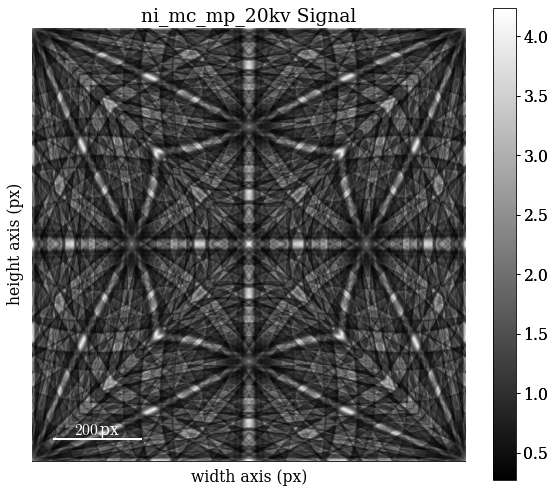

In [4]:
mp.plot(navigator=None)

Extract the phase and change the lattice parameters from nm to Ångström

In [5]:
phase = mp.phase
lat = phase.structure.lattice
lat.setLatPar(lat.a * 10, lat.b * 10, lat.c * 10)

print(phase)
print(phase.structure)

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
lattice=Lattice(a=3.5236, b=3.5236, c=3.5236, alpha=90, beta=90, gamma=90)
28   0.000000 0.000000 0.000000 1.0000


Extract a (7, 7) grid of patterns using [EBSD.extract_grid()](../reference/generated/kikuchipy.signals.EBSD.extract_grid.rst)

In [6]:
grid_shape = (4, 4)
s2, idx = s.extract_grid(grid_shape, return_indices=True)
s2

<LazyEBSD, title: EDAX-Ni Scan 1, dimensions: (4, 4|60, 60)>

Inspect an image quality map (we have to compute the returned Dask array since we loaded data lazily above)

In [7]:
iq = s.get_image_quality()
iq = iq.compute()

Plot the positions of the extracted patterns on the grid

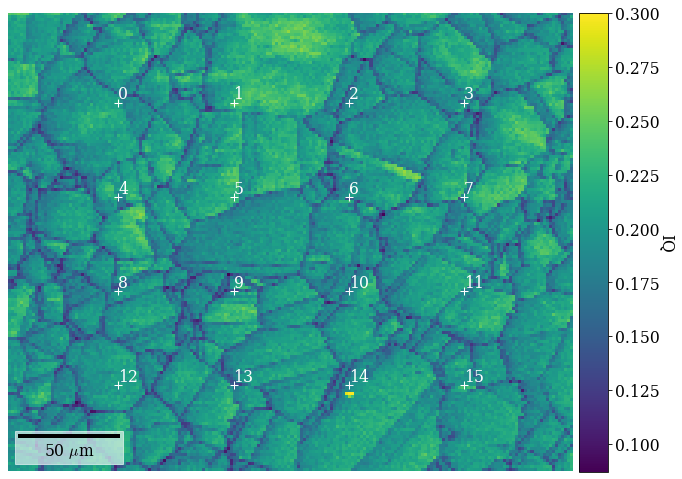

In [8]:
# For convenience, use the plot method of the crystal map attached to the EBSD
# signal to the IQ map. Must be 1D.
iq = iq.ravel()
s.xmap.scan_unit = "um"
fig = s.xmap.plot(
    iq,
    vmax=0.3,
    remove_padding=True,
    colorbar=True,
    colorbar_label="IQ",
    return_figure=True,
)

kp.draw.plot_pattern_positions_in_map(
    rc=idx.reshape(2, -1).T,
    roi_shape=s.xmap.shape,
    axis=fig.axes[0],
    color="w",
)

Plot the grid patterns

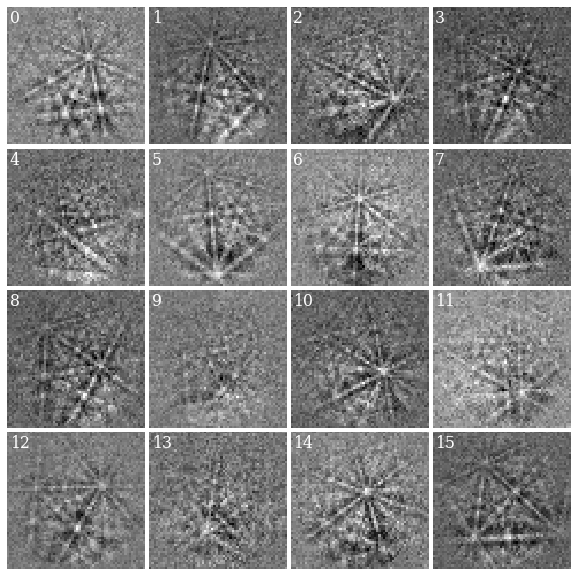

In [9]:
fig = plt.figure()
_ = hs.plot.plot_images(
    s2,
    fig=fig,
    axes_decor=None,
    label=None,
    colorbar=False,
    per_row=grid_shape[0],
    padding=dict(wspace=0.03, hspace=0.03),
    tight_layout=True,
)
for i, ax in enumerate(fig.axes):
    ax.text(1, 1, i, va="top", ha="left", c="w")
    ax.axis("off")

## Estimate average PC from grid of patterns

Create a PyEBSDIndex indexer instance.
We use relevant sample-detector geometry values read from the EDAX file, stored in the [kikuchipy.signals.EBSD.detector](../reference/generated/kikuchipy.signals.EBSD.detector.rst) attribute.
Note that the PC is in the Bruker convention (used internally); see the [reference frames tutorial](reference_frames.ipynb) for details.

In [10]:
det = s.detector
det.binning = 8
det.px_size = 59.2
det

EBSDDetector (60, 60), px_size 59.2 um, binning 8, tilt 10.0, azimuthal 0.0, pc (0.507, 0.262, 0.558)

In [11]:
indexer = ebsd_index.EBSDIndexer(
    phaselist=["FCC"],
    vendor="kikuchipy",
    sampleTilt=det.sample_tilt,
    camElev=det.tilt,
    patDim=det.shape,
    nBands=9,  # Default
)

Estimate the PC of the 49 grid patterns.
Note that PyEBSDIndex requires patterns as a NumPy array with a single navigation dimension.

In [12]:
s2_patterns = s2.data.reshape((-1,) + det.shape)

pc_grid = pcopt.optimize(
    pats=s2_patterns, indexer=indexer, PC0=det.pc, batch=True
)

# Print mean and standard deviation
print(pc_grid.mean(axis=0))
print(pc_grid.std(axis=0))

[0.50563831 0.27400748 0.55916301]
[0.01152403 0.00986163 0.0098673 ]


Store the new PCs in a new detector instance and plot them

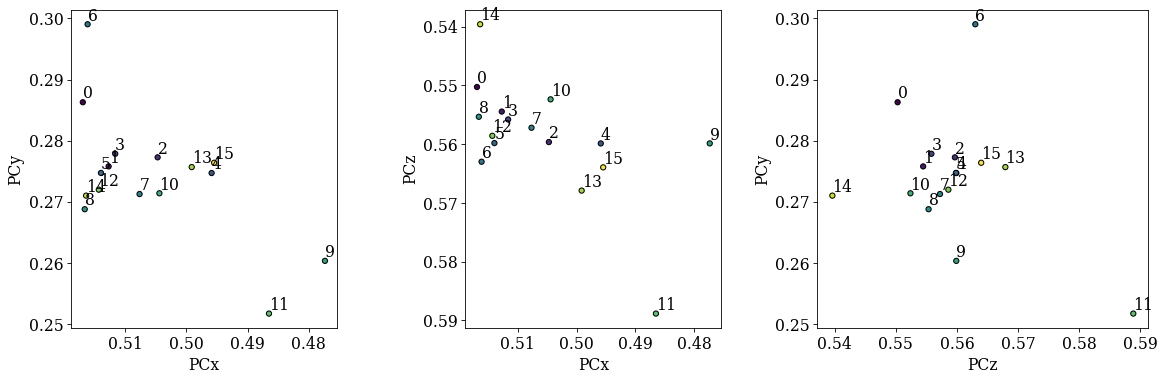

In [13]:
det_grid_hi = det.deepcopy()
det_grid_hi.pc = pc_grid.reshape(grid_shape + (3,))

det_grid_hi.plot_pc("scatter", annotate=True)

The PCs are quite dispersed, but most seem to cluster around an average PC.
We should only use the average PC from these initial estimates and not try to fit a plane to them, as they do not seem to vary in a grid.

Index the grid patterns using Hough indexing with the initially estimated PCs (to be averaged later!)

Radon Time: 0.014021096998476423
Convolution Time: 0.005622964003123343
Peak ID Time: 0.0011660360032692552
Band Label Time: 0.016146843998285476
Total Band Find Time: 0.03697889600152848


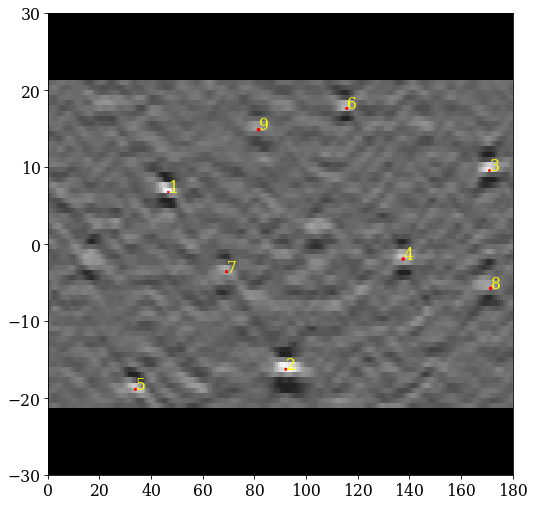

Band Vote Time:  0.02797808500326937


In [14]:
# Figure for PyEBSDIndex to plot Hough transform of first pattern into,
# with nine sought after bands highlighted
fig = plt.figure()

hi_grid, *_ = indexer.index_pats(
    patsin=s2_patterns, PC=det_grid_hi.pc_flattened, verbose=2
)

Generate a [CrystalMap](https://orix.readthedocs.io/en/latest/reference/generated/orix.crystal_map.CrystalMap.html) for saving and further analysis of the Hough indexing results (see the [Hough indexing tutorial](hough_indexing.ipynb) or [PyEBSDIndex' Hough indexing tutorial](https://pyebsdindex.readthedocs.io/en/latest/tutorials/ebsd_index_demo.html) for details on the indexing result parameters)

In [15]:
xy, _ = create_coordinate_arrays(
    grid_shape,
    step_sizes=(s2.axes_manager["y"].scale, s2.axes_manager["x"].scale),
)
xmap_grid_hi = CrystalMap(
    rotations=Rotation(hi_grid[-1]["quat"]),
    x=xy["x"],
    y=xy["y"],
    phase_list=PhaseList(phase),
    prop=dict(fit=hi_grid[-1]["fit"], cm=hi_grid[-1]["cm"]),
    scan_unit="um",
)
xmap_grid_hi

Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0   16 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm
Scan unit: um

Plot the confidence metric (possible values in the range [0, 1])

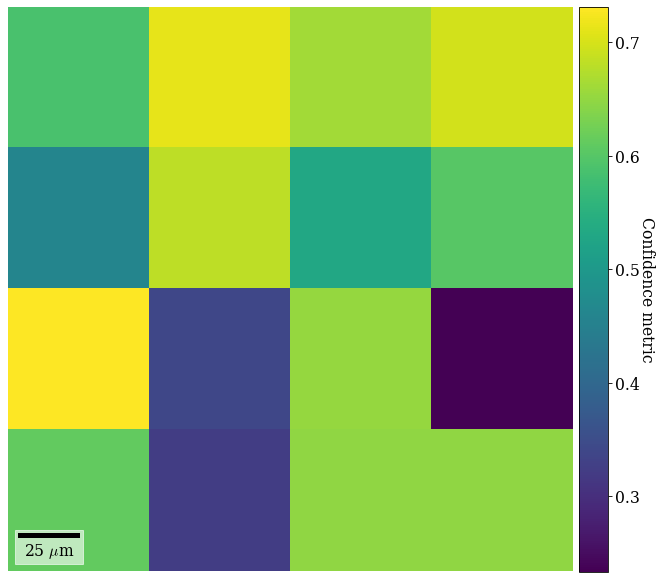

In [16]:
xmap_grid_hi.plot(
    "cm",
    remove_padding=True,
    colorbar=True,
    colorbar_label="Confidence metric",
)

We see that PyEBSDIndex is fairly confident on the indexed solution for most patterns.
Patterns with a low confidence seem to be located on boundaries in the IQ map above.

Let's refine both the PCs and orientations using pattern matching (see the [pattern matching tutorial](pattern_matching.ipynb) for details).
We will use the Nelder-Mead implementation from the NLopt package, which is an optional dependency of kikuchipy (see [the installation guide](../user/installation.rst#with-pip) for details).

In [17]:
# Signal mask, with True values *not* used in matching
mask = ~kp.filters.Window("circular", shape=det_grid_hi.shape).astype(bool)

xmap_grid_ref, det_grid_ref = s2.refine_orientation_projection_center(
    xmap=xmap_grid_hi,
    detector=det_grid_hi,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[10, 10, 10, 0.1, 0.1, 0.1],  # Wide (!) trust region
    rtol=1e-7,
    signal_mask=mask,
    # Recommended when refining few patterns
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [10.  10.  10.   0.1  0.1  0.1]
  Relative tolerance: 1e-07
Refining 16 orientation(s) and projection center(s):
[########################################] | 100% Completed | 1.72 sms
Refinement speed: 9.25218 patterns/s


Print scores and the mean and standard deviation of the refined (PCx, PCy, PCz)

In [18]:
print(xmap_grid_ref.scores.mean())
print(det_grid_ref.pc_average)
print(det_grid_ref.pc_flattened.std(axis=0))

0.47512124106287956
[0.50990584 0.26678132 0.55953043]
[0.00435239 0.00372176 0.00318409]


Plot the refined PCs as we did above

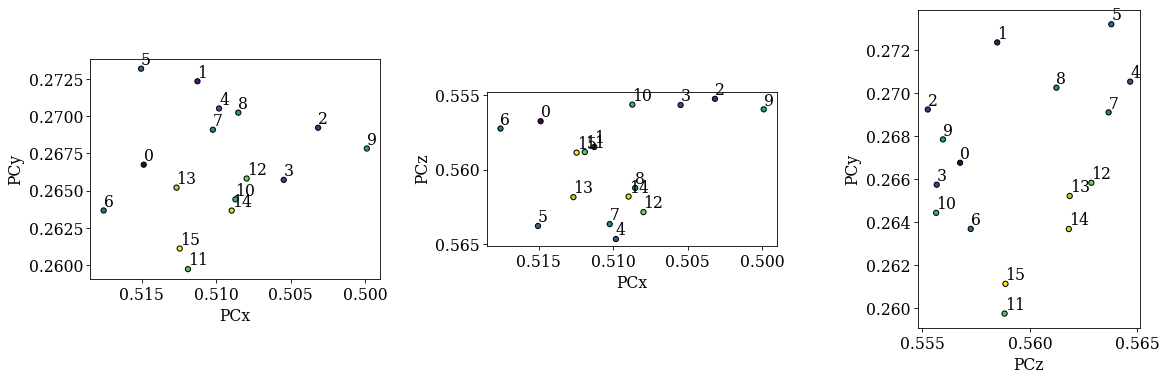

In [19]:
det_grid_ref.plot_pc("scatter", annotate=True)

The PCs are still quite spread out, but the deviations from the mean are much smaller compared to the PCs from Hough indexing alone.

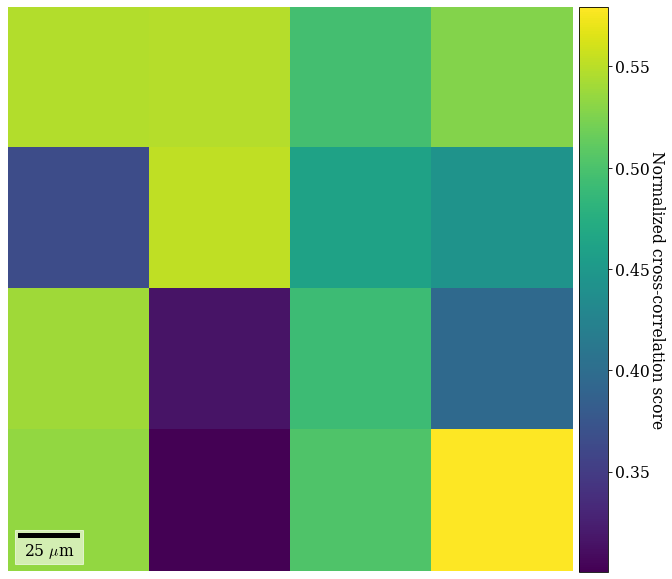

In [20]:
xmap_grid_ref.plot(
    "scores",
    remove_padding=True,
    colorbar=True,
    colorbar_label="Normalized cross-correlation score",
)

Let's inspect the refined orientations by plotting center lines of the Kikuchi bands on top of patterns (see the [geometrical EBSD simulations tutorial](geometrical_ebsd_simulations.ipynb) for details)

In [21]:
rlv = ReciprocalLatticeVector.from_min_dspacing(phase, 1)
rlv.sanitise_phase()  # Expand unit cell
rlv.calculate_structure_factor()
structure_factor = abs(rlv.structure_factor)
rlv = rlv[structure_factor > 0.6 * structure_factor.max()]
rlv.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    2.034    11.8     140.0     100.0      8   
 2 0 0    1.762    10.4     108.2      77.3      6   
 2 2 0    1.246     7.4     55.0       39.3      12  


In [22]:
simulator = kp.simulations.KikuchiPatternSimulator(rlv)

Get simulations

In [23]:
sim = simulator.on_detector(
    det_grid_ref, xmap_grid_ref.rotations.reshape(*xmap_grid_ref.shape)
)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 104.47 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.33 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 101.22 ms


Plot geometrical simulations on top of patterns

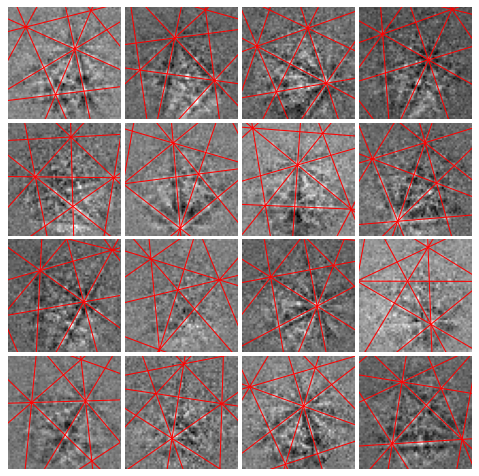

In [24]:
fig, axes = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1])
for i in np.ndindex(grid_shape):
    axes[i].imshow(s2.data[i], cmap="gray")
    axes[i].axis("off")
    lines = sim.as_collections(i)[0]
    axes[i].add_collection(lines)
fig.subplots_adjust(wspace=0.03, hspace=0.03)

Most simulated lines seem lie on top of experimental bands, as expected.

Let's *now* compute the average PC weighted by correlation scores

In [25]:
det_ref = det_grid_ref.deepcopy()
det_ref.pc = np.average(
    det_grid_ref.pc.reshape((-1, 3)), weights=xmap_grid_ref.scores, axis=0
)

print("Estimated PC:", det_ref.pc)
print("EDAX OIM PC: ", det.pc)
print("Difference:  ", det_ref.pc - det.pc)

Estimated PC: [[0.51008417 0.26685661 0.55947204]]
EDAX OIM PC:  [[0.50726193 0.26207614 0.55848867]]
Difference:   [[0.00282224 0.00478047 0.00098337]]


We see that the PC we obtained with our routine above deviates little from the EDAX OIM PC.
This is not surprising since we used the EDAX OIM PC as an initial guess.
Based on the geometrical simulations above, these PC values seem OK.

## Index all patterns with Hough indexing

Let's index the entire map of patterns with PyEBSDIndex, using our indexer from before but with the new estimated PC

Radon Time: 1.590590311017877
Convolution Time: 2.5143780069993227
Peak ID Time: 1.9474273490122869
Band Label Time: 5.644993639965833
Total Band Find Time: 11.697861042994191


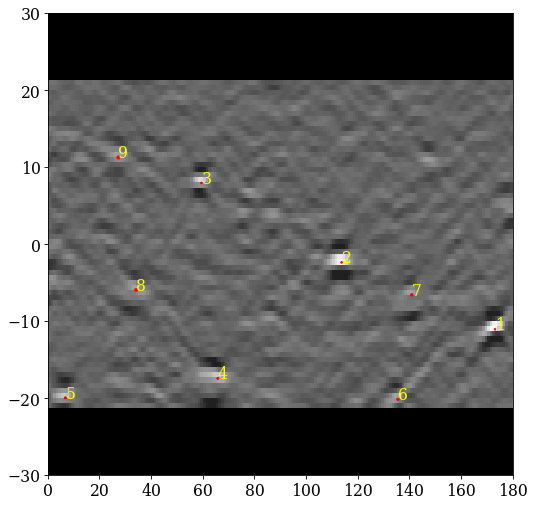

Band Vote Time:  15.242592889997468


In [26]:
plt.figure()
hi_all, *_ = indexer.index_pats(
    patsin=s.data.reshape((-1,) + det_ref.shape), PC=det_ref.pc, verbose=2
)

Some patterns might be considered "not indexed" if their pattern fit is greater than 3$^{\circ}$, giving the corresponding map points phase IDs of -1 and quaternions of `NaN`.
Our refinement routine does not handle `NaN` quaternions, so we set them equal to the identity rotation

In [27]:
phase_id = hi_all[-1]["phase"]
print(np.any(phase_id == -1))

rot = Rotation(hi_all[-1]["quat"])
rot[phase_id == -1] = Rotation.identity()

True


Refinement can so far only be done for single phase maps, so we set the phase ID to Ni for all points.

In [28]:
xy, _ = create_coordinate_arrays(
    s.axes_manager.navigation_shape[::-1],
    step_sizes=(s.axes_manager["y"].scale, s.axes_manager["x"].scale),
)
xmap_all = CrystalMap(
    rotations=rot,
    x=xy["x"],
    y=xy["y"],
    phase_list=PhaseList(phase),
    prop=dict(fit=hi_all[-1]["fit"], cm=hi_all[-1]["cm"]),
    scan_unit="um",
)
xmap_all

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  28086 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm
Scan unit: um

Let's plot the inverse pole figure (IPF)-Z color map.
First, we must get a color key, potentially setting the sample direction if we want another IPF than IPF-Z

In [29]:
pgm3m = xmap_all.phases[0].point_group

ckey = plot.IPFColorKeyTSL(pgm3m)
print(ckey)

IPFColorKeyTSL, symmetry: m-3m, direction: [0 0 1]


Plot the map with the IPF color key next to the map

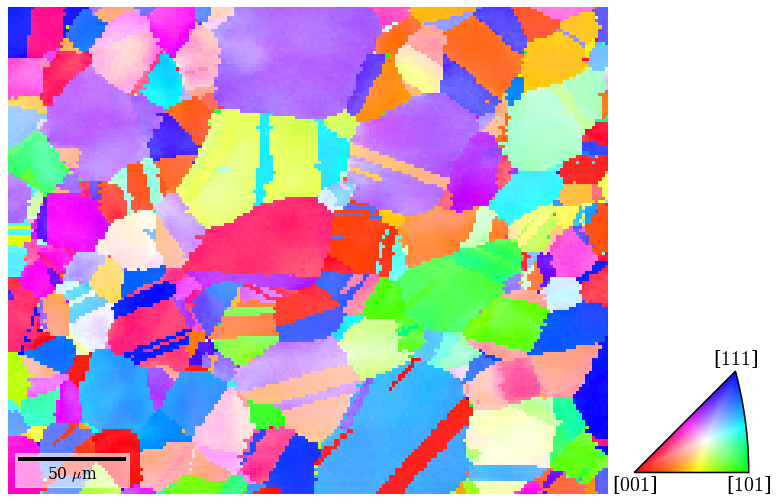

In [30]:
rgbz = ckey.orientation2color(xmap_all.orientations)

fig = xmap_all.plot(rgbz, remove_padding=True, return_figure=True)

# Place color key next to map
rect = [1.04, 0.115, 0.2, 0.2]  # [Left, bottom, width, height]
ax_ckey = fig.add_axes(rect, projection="ipf", symmetry=pgm3m)
ax_ckey.plot_ipf_color_key()
ax_ckey.set_title(None)
ax_ckey.patch.set_facecolor("None")

We see that Hough indexing with PyEBSDIndex is able to index the patterns quite convincingly.

## Fit PC in vertical direction

Finally, we'll refine orientations and PCs in a vertical slice, average the PCs in the horizontal direction, and inspect the PCs and PC errors as a function of the vertical position.
We'll use the same vertical slice as <cite data-cite="pang2020global">Pang et al. (2020)</cite> use.

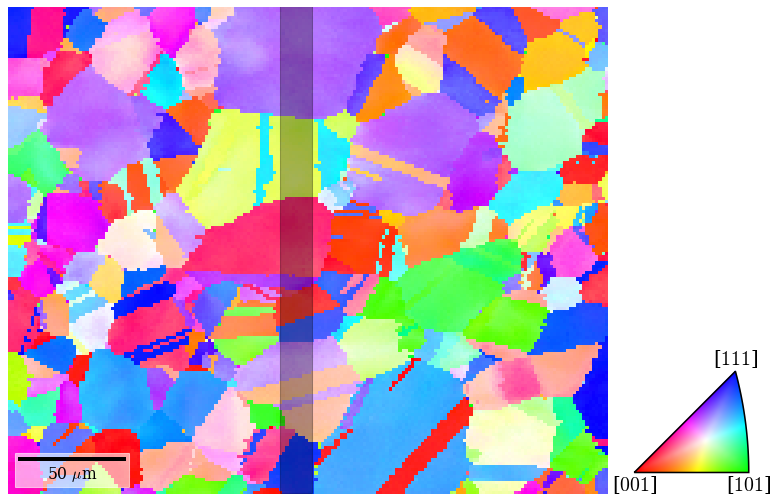

In [31]:
# Get tuple of slices to extract data of interest
x0, x1 = 84, 84 + 10
y0, y1 = 0, xmap_all.shape[0]
slices = (slice(y0, y1), slice(x0, x1))

# Rectangle to highlight the slice on top of IPF-Z map
rect_slice = mpatches.Rectangle(
    xy=(x0, y0 - 1),
    width=x1 - x0,
    height=y1 - y0,
    color="k",
    alpha=0.3,
)
fig.axes[0].add_artist(rect_slice)
fig  # Show the figure again

Crystal map (orientations) within the slice

In [32]:
xmap_slice = xmap_all[slices]
xmap_slice

Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  1510 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm
Scan unit: um

Patterns within the slice

In [33]:
s_slice = s.inav[x0:x1]
s_slice

<LazyEBSD, title: EDAX-Ni Scan 1, dimensions: (10, 151|60, 60)>

Orientation colors (IPF-Z) within the slice

In [34]:
rgbz_slice = rgbz.reshape(xmap_all.shape + (3,))[slices]
rgbz_slice = rgbz_slice[:, -1, :]

We'll use the exact same trust region (bounds) on the orientations (1$^{\circ}$) and PCs in EMsoft's convention (5 px for $x_{pc}$ and $y_{pc}$ and 500 $\mu$m for $L$) in the refinement as used by
<cite data-cite="pang2020global">Pang et al. (2020)</cite>.

In [35]:
trust_region = [
    1,
    1,
    1,
    5 / (det_ref.ncols * det_ref.binning),
    5 / (det_ref.nrows * det_ref.binning),
    500 / (det_ref.nrows * det_ref.px_size * det_ref.binning),
]
trust_region

[1, 1, 1, 0.010416666666666666, 0.010416666666666666, 0.01759572072072072]

Refine orientations and PCs of patterns in the slice, using the Hough indexed orientations and the estimated average PC as initial guesses

In [36]:
xmap_slice_ref, det_slice_ref = s_slice.refine_orientation_projection_center(
    xmap=xmap_slice,
    detector=det_ref,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=trust_region,
    rtol=1e-7,
    signal_mask=mask,
)

print(xmap_slice_ref.scores.mean())
print(det_slice_ref.pc_average)
print(det_slice_ref.pc_flattened.std(axis=0))

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [1.      1.      1.      0.01042 0.01042 0.0176 ]
  Relative tolerance: 1e-07
Refining 1510 orientation(s) and projection center(s):
[########################################] | 100% Completed | 128.74 s
Refinement speed: 11.72636 patterns/s
0.5219001930478393
[0.50995404 0.26701027 0.55998725]
[0.00361591 0.00356503 0.00292316]


To compare our results to those of <cite data-cite="pang2020global">Pang et al. (2020)</cite>, we will plot the PCs in EMsoft's version 4 definition (see [EBSDDetector.pc_emsoft()](../reference/generated/kikuchipy.detectors.EBSDDetector.pc_emsoft.rst) for details on the conversion from Bruker's definition)

In [37]:
pc_slice = det_slice_ref.pc_emsoft(version=4)

# Average horizontally
pc_slice_mean = pc_slice.mean(axis=1)

# Reshape for easy plotting
pcx, pcy, pcz = pc_slice_mean.reshape((-1, 3)).T

Get curves for the expected changes in PCs based on the equations given at the start

In [38]:
y_pos_um = np.arange(y1) * xmap_all.dy
y_pos_px = y_pos_um / det_ref.px_size

alpha = np.deg2rad(90 - det_ref.sample_tilt + det_ref.tilt)

# Find best intercept value for PCy and PCz by curve fitting
pcy_inter, _ = curve_fit(lambda y, a: a + np.cos(alpha) * y, y_pos_px, pcy)
pcz_inter, _ = curve_fit(lambda y, a: a + np.sin(alpha) * y, y_pos_um, pcz)

pcx_fit = np.ones(y_pos_um.size) * pcx.mean()
pcy_fit = pcy_inter[0] + np.cos(alpha) * y_pos_px
pcz_fit = pcz_inter[0] + np.sin(alpha) * y_pos_um

Get the distance (error) between measured and expected changes, and the cumulative fraction of these distances

In [39]:
# Deviations
pcx_err = abs(pcx_fit - pcx)
pcy_err = abs(pcy_fit - pcy)
pcz_err = abs(pcz_fit - pcz)

# Cumulative fraction
pcx_err_sorted = np.sort(pcx_err)
pcy_err_sorted = np.sort(pcy_err)
pcz_err_sorted = np.sort(pcz_err)
y_cum = np.arange(pcx.size) / pcx.size

Let's find out the 90th percentile error in each PC coefficient

In [40]:
idx_pct = np.where(y_cum > 0.9)[0][0]
pcx_err_pct = pcx_err_sorted[idx_pct]
pcy_err_pct = pcy_err_sorted[idx_pct]
pcz_err_pct = pcz_err_sorted[idx_pct]

print(
    pcx_err_pct / det_ref.binning,
    pcy_err_pct / det_ref.binning,
    pcz_err_pct / (det_ref.px_size * det_ref.binning),
)

0.15416694764354033 0.1344453767671112 0.1391038616964854


As Pang and co-workers found, for $x_{pc}$ and $y_{pc}$, 90% of points have an error less than 0.2% of the detector width, while for $L$, 90% of points have an error less than 0.15%.

Let's plot the experimental and expected changes of the PCs along the vertical direction, along with the cumulative fractions.
The experimental changes are colored according to the grain orientations from the IPF-Z above.

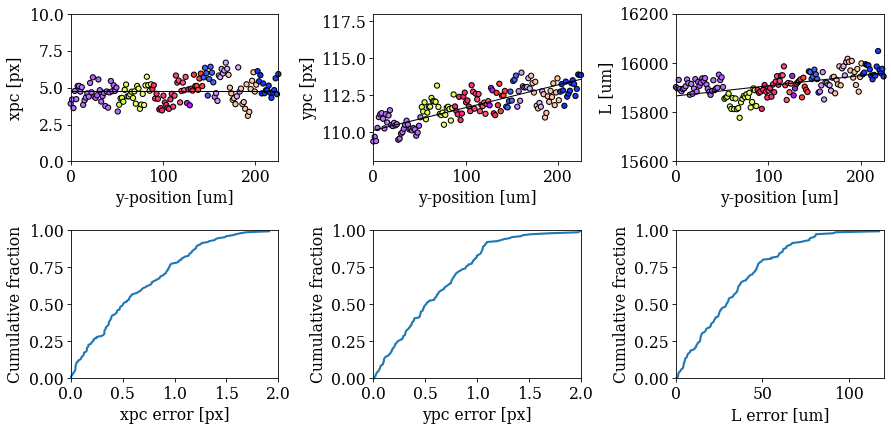

In [41]:
# Common keyword arguments
scatter_kw = dict(c=rgbz_slice, ec="k", clip_on=False)
scatter_set_kw = dict(xlabel="y-position [um]", xlim=(0, y_pos_um[-1]))
plot_kw = dict(lw=2, clip_on=False)
plot_set_kw = dict(ylabel="Cumulative fraction", ylim=(0, 1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.ravel()

# PC vs. y-position w/ best fit
ax0.scatter(y_pos_um, pcx, **scatter_kw)
ax1.scatter(y_pos_um, pcy, **scatter_kw)
ax2.scatter(y_pos_um, pcz, **scatter_kw)
ax0.plot(y_pos_um, pcx_fit, c="k")
ax1.plot(y_pos_um, pcy_fit.ravel(), c="k")
ax2.plot(y_pos_um, pcz_fit.ravel(), c="k")
ax0.set(ylabel="xpc [px]", ylim=(0, 10), **scatter_set_kw)
ax1.set(ylabel="ypc [px]", ylim=(108, 118), **scatter_set_kw)
ax2.set(ylabel="L [um]", ylim=(15600, 16200), **scatter_set_kw)

# Cumulative fraction of deviations
ax3.plot(pcx_err_sorted, y_cum, **plot_kw)
ax4.plot(pcy_err_sorted, y_cum, **plot_kw)
ax5.plot(pcz_err_sorted, y_cum, **plot_kw)
ax3.set(xlabel="xpc error [px]", xlim=(0, 2), **plot_set_kw)
ax4.set(xlabel="ypc error [px]", xlim=(0, 2), **plot_set_kw)
ax5.set(xlabel="L error [um]", xlim=(0, 120), **plot_set_kw)

fig.tight_layout()

There are clear systematic deviations in the PC away from the expected PC caused by grain orientations.
See the discussion by <cite data-cite="pang2020global">Pang et al. (2020)</cite> for possible causes of this and more details on the above analysis.

In conclusion, coming back to the point made in the beginning: Whenever possible, we should estimate a PC from not only many patterns, but from many patterns from different grains as well.